# Introduction 
This notebook expands in **full detail an implementation of the Newton-Raphson algorithm** to one specific instance of the power flow problem
with 3 buses (cf. details in the lecture slides).

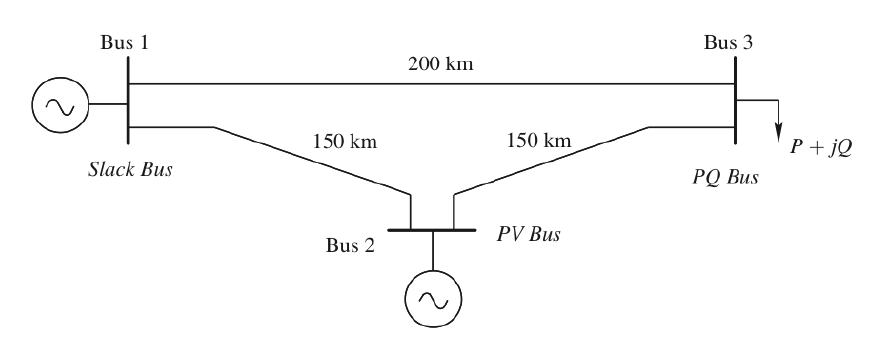

Example 5.4 given at page 89 of Ned Mohan's Book. Based on network shown at page 80 and gradually described in the other examples.

Buses:
 - Bus 1 is the slack, with voltage at 1 pu
 - Bus 2 is a PV bus, with voltage at 1.05 pu and drawing 2 pu of active power
 - Bus 3 is a PQ bus, consumed P = 5 pu and Q = 1 pu.

Lines:
 - 1 to 2: 150 km
 - 2 to 3: 150 km
 - 3 to 1: 200 km
 - X = 0.376 Ohm/km (at 6h Hz)
 - R = 0.037 Ohm/km
 - Shunt susceptances are ignored (4.5e-6 S/km)


Voltage base (3-phase): 345 kV
Power base (3-phase): 100 MVA

In a real solver such as PandaPower, a modelling layer and some data structures allow to decouple the modelling part from the solution process, and make it much more flexible.

# Imports

In [1]:
from math import sin, cos, pi
import numpy as np
import pandas as pd

# Per unit  (3-phase values)

In [2]:
# Per unit 
Pbase = 100  # MVA
Vbase = 345  # kV

Zbase  = Vbase**2/Pbase

# Line Data

In [3]:
X_km = 0.376    # ohm/km
R_km = 0.037    # ohm/km
l01_km = 150    # km
l12_km = 150    # km
l02_km = 200    # km

# What are the values we know, and those we don't?

In [4]:
# Bus index      [ 1    ,     2 ,     3 ]
P = np.array(    [np.nan,     -2.,    5.]) # p.u.
Q = np.array(    [np.nan, np.nan,     1.]) # p.u.
Vmag = np.array( [     1,   1.05, np.nan]) # p.u.
Theta = np.array([     0, np.nan, np.nan]) # p.u.

# Compute the line admittances

In [5]:
Z_01 = (R_km+1j*X_km)*l01_km / Zbase # p.u.
Z_02 = (R_km+1j*X_km)*l02_km / Zbase # p.u.
Z_12 = (R_km+1j*X_km)*l12_km / Zbase # p.u.
Y_01 = 1./Z_01 # p.u.
Y_02 = 1./Z_02 # p.u.
Y_12 = 1./Z_12 # p.u.

# Create the admittance matrix (using the inspection rule), and separate its real and imaginary parts

In [6]:
Y = np.array([[Y_01 + Y_02,     -Y_01,     -Y_02], 
              [-Y_01      , Y_01+Y_12,     -Y_12], 
              [-Y_02      ,     -Y_12, Y_02+Y_12]])

G = Y.real  # Conductance matrix
B = Y.imag  # Susceptance matrix

# Start of Newton-Raphson algorithm

In [7]:
# Initialize V -> replace nans by 1 pu.
print(Vmag)
print(Theta)

Vmag = np.array([1. if np.isnan(x) else x for x in Vmag])
# Initialize Theta -> replace nans by 0 rad.
Theta = np.array([0. if np.isnan(x) else x for x in Theta])

print(Vmag)
print(Theta)

[1.   1.05  nan]
[ 0. nan nan]
[1.   1.05 1.  ]
[0. 0. 0.]


## Encode the power flow equations at buses where P or Q is known

In [8]:
def compute_power_error():
    
    # Step 1: apply the power flow equations to (re)estimate P and Q injected as a function of Vmag and Theta 
    # P1_est(Vmag, Theta)
    P_1_est =-(G[1][1]*Vmag[1]**2 \
           + Vmag[1]*(Vmag[0]*(G[1][0]*cos(Theta[1] - Theta[0]) + B[1][0]*sin(Theta[1] - Theta[0])) 
                      + Vmag[2]*(G[1][2]*cos(Theta[1] - Theta[2]) + B[1][2]*sin(Theta[1] - Theta[2]))))
    
    # P2_est(Vmag, Theta)
    P_2_est = -(G[2][2]*Vmag[2]**2 \
              + Vmag[2]*(Vmag[0]*(G[2][0]*cos(Theta[2] - Theta[0]) + B[2][0]*sin(Theta[2] - Theta[0])) 
                         + Vmag[1]*(G[2][1]*cos(Theta[2] - Theta[1]) + B[2][1]*sin(Theta[2] - Theta[1]))))
    
    # Q2_est(Vmag, Theta)
    Q_2_est = -(-B[2][2]*Vmag[2]**2 \
              + Vmag[2]*(Vmag[0]*(G[2][0]*sin(Theta[2] - Theta[0]) - B[2][0]*cos(Theta[2] - Theta[0])) 
                         + Vmag[1]*(G[2][1]*sin(Theta[2] - Theta[1]) - B[2][1]*cos(Theta[2] - Theta[1]))))

    # Step 2: Compute the error between estimated and known powers
    power_error = [P[1] - P_1_est, P[2] - P_2_est, Q[2] - Q_2_est]
    
    return power_error # the error on the injected powers will allow us to update Vmag and Theta 

##  To update Vmag and Theta, we need the compute the Jacobian

The Jacobian gives us the sensitivity of the active and reactive powers injected (at the buses where we have measurements of P and Q) as a function of Vmag and Theta

In [9]:
def compute_J():
    ## Jacobian ##
    J = np.array([
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]
    ],dtype=float)
    
    # J(0,0)=dP1/dtheta1
    J[0][0] = Vmag[1]*(Vmag[0]*(-G[1][0]*sin(Theta[1]-Theta[0])+B[1][0]*cos(Theta[1]-Theta[0])) +
                        Vmag[2]*(-G[1][2]*sin(Theta[1]-Theta[2])+B[1][2]*cos(Theta[1]-Theta[2])))
    # J(0,1)=dP1/dtheta2
    J[0][1] = Vmag[1] * (Vmag[2]*(G[1][2]*sin(Theta[1]-Theta[2]) - B[1][2]*cos(Theta[1]-Theta[2])))

    # J(0,2)=dP1/dV2
    J[0][2] = Vmag[1]*((G[1][2]*cos(Theta[1]-Theta[2]) + B[1][2]*sin(Theta[1]-Theta[2])))

    # J(1,0)=dP2/dtheta1
    J[1][0] = Vmag[2] * (Vmag[1]*(G[2][1]*sin(Theta[2]-Theta[1]) - B[2][1]*cos(Theta[2]-Theta[1])))

    # J(1,1)=dP2/dtheta2
    J[1][1] = Vmag[2]*(Vmag[0]*(-G[2][0]*sin(Theta[2]-Theta[0])+B[2][0]*cos(Theta[2]-Theta[0])) +
                        Vmag[1]*(-G[2][1]*sin(Theta[2]-Theta[1])+B[2][1]*cos(Theta[2]-Theta[1])))

    # J(1,2)=dP2/dV2
    J[1][2] = 2*G[2][2]*Vmag[2] + Vmag[0]*(G[2][0]*cos(Theta[2]-Theta[0])+B[2][0]*sin(
        Theta[2]-Theta[0])) + Vmag[1]*(G[2][1]*cos(Theta[2]-Theta[1])+B[2][1]*sin(Theta[2]-Theta[1]))

    # J(2,0)=dQ2/dtheta1
    J[2][0] = Vmag[2] * (Vmag[1]*(-G[2][1]*cos(Theta[2]-Theta[1]) - B[2][1]*sin(Theta[2]-Theta[1])))

    # J(2,1)=dQ2/dtheta2
    J[2][1] = Vmag[2]*(Vmag[0]*(G[2][0]*cos(Theta[2]-Theta[0])+B[2][0]*sin(Theta[2]-Theta[0])) +
                        Vmag[1]*(G[2][1]*cos(Theta[2]-Theta[1])+B[2][1]*sin(Theta[2]-Theta[1])))

    # J(2,2)=dQ2/dV2
    J[2][2] = - 2*B[2][2]*Vmag[2] + Vmag[0]*(G[2][0]*sin(Theta[2]-Theta[0])-B[2][0]*cos(
        Theta[2]-Theta[0])) + Vmag[1]*(G[2][1]*sin(Theta[2]-Theta[1])-B[2][1]*cos(Theta[2]-Theta[1]))
    
    return -J

## Given the power estimation error and the sensitivity, we can update Vmag and Theta

In [10]:
def solve_linear_system(J, power_errors):
    # Solve Ax = b where A is J and b is the power_errors
    deltas = np.linalg.solve(J, power_errors)
    return deltas

"""Update the unknown values (V and theta for PQ buses and theta for PV buses)"""

def update_V(Theta_1, Theta_2, Vmag_2, deltas):
    # Update the approximated solutions
    Theta_1 += deltas[0]  # delta_Theta[1]
    Theta_2 += deltas[1]  # delta_Theta[2]
    Vmag_2 += deltas[2]  # delta_Vmag[2]
    return Theta_1, Theta_2, Vmag_2

## Init the N-R loop

In [11]:
# Newton-Raphson algorithmic parameters
N_ITER_MAX = 100
TOLERANCE = 1e-4

# Newton-Raphson iteration counter and flag
n_iter = 0
conv_flag = 0

## The actual N-R loop


In [12]:
while(conv_flag == 0):
    power_errors = compute_power_error()
    if max(map(abs, power_errors)) > TOLERANCE or n_iter > N_ITER_MAX:
        conv_flag = 0
    else:
        conv_flag = 1
    J = compute_J()

    deltas = solve_linear_system(J, power_errors)
    Theta[1], Theta[2], Vmag[2] = update_V(Theta[1], Theta[2], Vmag[2], deltas)
    print("Iteration %d: P1_exact - P1_est = %.8f, P2_exact - P2_est = %.8f, Q2_exact - Q2_est = %.8f" %
            (n_iter, power_errors[0], power_errors[1], power_errors[2]))
    n_iter += 1
    if n_iter > N_ITER_MAX:
        print('Maximum number of iteration reached. Calculated solution may not be correct.')

Iteration 0: P1_exact - P1_est = -1.78403814, P2_exact - P2_est = 4.89716102, Q2_exact - Q2_est = -0.04506638
Iteration 1: P1_exact - P1_est = -0.02063201, P2_exact - P2_est = 0.10457299, Q2_exact - Q2_est = 0.31253471
Iteration 2: P1_exact - P1_est = -0.00055264, P2_exact - P2_est = 0.00152721, Q2_exact - Q2_est = 0.00330269
Iteration 3: P1_exact - P1_est = -0.00000010, P2_exact - P2_est = 0.00000024, Q2_exact - Q2_est = 0.00000041


In [13]:
print("Solution (in pu): Theta[1] = %.3f [deg], Theta[2] = %.3f [deg], Vmag[2] = %.3f" %
              (Theta[1]*180/pi, Theta[2]*180/pi, Vmag[2]))

P[0] = -(G[0][0]*Vmag[0]**2 + Vmag[0]*(Vmag[1]*(G[0][1]*cos(Theta[0] - Theta[1]) + B[0][1]*sin(
    Theta[0] - Theta[1])) + Vmag[2]*(G[0][2]*cos(Theta[0] - Theta[2]) + B[0][2]*sin(Theta[0] - Theta[2]))))
Q[0] = -(-B[0][0]*Vmag[0]**2 + Vmag[0]*(Vmag[1]*(G[0][1]*sin(Theta[0] - Theta[1]) - B[0][1]*cos(
    Theta[0] - Theta[1])) + Vmag[2]*(G[0][2]*sin(Theta[0] - Theta[2]) - B[0][2]*cos(Theta[0] - Theta[2]))))
Q[1] = -(-B[1][1]*Vmag[1]**2 + Vmag[1]*(Vmag[0]*(G[1][0]*sin(Theta[1] - Theta[0]) - B[1][0]*cos(
    Theta[1] - Theta[0])) + Vmag[2]*(G[1][2]*sin(Theta[1] - Theta[2]) - B[1][2]*cos(Theta[1] - Theta[2]))))

solution_array = np.transpose([Vmag, Theta*180/pi, P*Pbase, Q*Pbase])

# [V3_mag, V3_phase*180/pi, -P3*Pbase, -Q3*Pbase]]
col_names = ["vm_pu", "va_degree", "p_mw", "q_mvar"]
res_bus = pd.DataFrame(solution_array, columns=col_names)

Solution (in pu): Theta[1] = -2.066 [deg], Theta[2] = -8.787 [deg], Vmag[2] = 0.978


In [14]:
from IPython.display import display, HTML

display(HTML(res_bus.to_html()))

,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,-308.377053,81.610978
1,1.050000,-2.066481,-200.000000,-266.739953
2,0.978114,-8.787327,500.000000,100.000000
